In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import feature_column
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, RocCurveDisplay, roc_auc_score, classification_report, confusion_matrix, roc_curve, accuracy_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

# Functions

In [ ]:
def plot_comparison(X_actual, X_decoded, index=None, text=None):
    """
    Plot comparison between actual input, decoded response, and the error for a given data point.

    Parameters:
    - X_actual: Actual data
    - X_decoded: Decoded (reconstructed) data by the autoencoder
    - index: Index of the sample data point. If None, a random sample is selected.
    """

    if index is None:
        index = np.random.randint(0, len(X_actual))

    error = np.abs(X_actual[index] - X_decoded[index])

    plt.figure(figsize=(10, 5))
    plt.plot(X_actual[index], label='Input', color='blue')
    plt.plot(X_decoded[index], label='Reconstruction', color='red', linestyle='--')
    plt.plot(error, label='Error', color='pink', linestyle=':')
    plt.xlabel('Feature Column Number')
    plt.ylabel('Standardised Value')
    plt.title(f'Comparison between actual input and decoded response for {text} data')
    plt.legend()
    plt.show()

In [ ]:
def plot_actual_vs_decoded(X_actual, X_decoded, n=10):
    """
    Plot comparison between actual input and decoded response for a few sample data points.

    Parameters:
    - X_actual: Actual data
    - X_decoded: Decoded (reconstructed) data by the autoencoder
    - n: Number of random data points to plot (default is 10)
    """
    # Randomly select n data points
    indices = np.random.choice(len(X_actual), n, replace=False)

    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(indices, 1):
        plt.subplot(2, n, i)
        plt.plot(X_actual[idx], label='Actual')
        plt.plot(X_decoded[idx], '--', label='Decoded')
        plt.title(f"Sample {i}")
        if i == 1:
            plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_reconstruction_error(normal_data, X_test, train_loss, test_loss, threshold):

  # Plot for Training Data Reconstruction Error
  plt.hist(train_loss, bins=50, alpha=0.6, color='blue')
  plt.xlabel("Train loss")
  plt.ylabel("Number of cases")
  plt.title("Normal Training Data Reconstruction Error Historgram")
  plt.show()

  # Plot for Test Data(Normal & Diseased) Reconstruction Error with Threshold
  fig, ax = plt.subplots()
  plt.hist(test_loss, bins=50, alpha=0.6, color='blue')
  plt.axvline(threshold, color='red', linestyle='--')
  plt.xlabel("Test loss")
  plt.ylabel("Number of cases")
  plt.title("Test Data (Normal & Diseased) Reconstruction Error Historgram With Threshold Line")
  plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax)

    # Adjust settings
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(title)
    plt.show()

In [ ]:
class Autoencoder(tf.keras.Model):
  def __init__(self, feature_count):
    self.feature_count = feature_count
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(self.feature_count, activation="relu"),
      tf.keras.layers.Dense(20, activation="relu"),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(12, activation="relu")])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(12, activation="relu"),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(20, activation="relu"),
      tf.keras.layers.Dense(self.feature_count, activation="linear")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# What is Multi-Layer Perceptron (MLP)?

Multi layer perceptron (MLP) is a supplement of feed forward neural network. It consists of three types of layers the input layer, output layer and hidden layer. The input layer receives the input signal to be processed. The required task such as prediction and classification is performed by the output layer. An arbitrary number of hidden layers that are placed in between the input and output layer are the true computational engine of the MLP. Similar to a feed forward network in a MLP the data flows in the forward direction from input to output layer. The neurons in the MLP are trained with the back propagation learning algorithm. MLPs are designed to approximate any continuous function and can solve problems which are not linearly separable. The major use cases of MLP are pattern classification, recognition, prediction and approximation.

The computations taking place at every neuron in the output and hidden layer are as follows:

<img src='Images/mlp2.png' width=100%>

# MLP Imputed Dataset

In [ ]:
df = pd.read_csv('datasets/numerical_data.csv')

In [ ]:
num_var = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
cat_var = ['Smoking', 'AgeCategory', 'Race', 'Diabetic', 'GenHealth', 'Asthma']
bin_var = ['AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'KidneyDisease', 'SkinCancer', 'PhysicalActivity']

In [ ]:
for column in df.columns:
    df[column] = df[column].astype(int)

In [ ]:
target = df.pop('HeartDisease')
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

In [ ]:
# Normalize numerical features
scaler = StandardScaler()
X_train[num_var] = scaler.fit_transform(X_train[num_var])
X_test[num_var] = scaler.transform(X_test[num_var])

Our data contains a mixture of categorical and numerical data. Let’s use TensorFlow`s Feature Columns.

<img src='Images/tf1.jpg'>

Feature columns allow us to bridge/process the raw data in our dataset to fit our model input data requirements. Furthermore, we can separate the model building process from the data preprocessing.

In [ ]:
# Define feature columns
feature_columns = []

# Numeric feature columns
for feature_name in num_var:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# Categorical feature columns (use one-hot encoding)
for feature_name in cat_var:
    vocabulary_list = df[feature_name].unique()
    cat_column = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary_list)
    one_hot_column = tf.feature_column.indicator_column(cat_column)
    feature_columns.append(one_hot_column)

# Binary feature columns (use one-hot encoding)
for feature_name in bin_var:
    vocabulary_list = df[feature_name].unique()
    bin_column = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary_list)
    one_hot_column = tf.feature_column.indicator_column(bin_column)
    feature_columns.append(one_hot_column)

In [ ]:
# Define a custom initializer with a constant value
initializer = tf.keras.initializers.Constant(0.5)

**Training:**

Our loss function is binary cross-entropy defined by:

<img src='Images/tf2.jpg'>

where y is binary indicator if the predicted class is correct for the current observation and p is the predicted probability.

In [ ]:
# Build and compile the model with the custom initializer for a specific layer
model = tf.keras.Sequential([
        tf.keras.layers.DenseFeatures(feature_columns),  # Input layer with feature columns
        tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer=initializer),  # Hidden layer with custom initializer
        tf.keras.layers.Dropout(rate=0.2),  # Dropout layer for regularization
        tf.keras.layers.Dense(units=128, activation='relu'),  # Another hidden layer
        tf.keras.layers.Dense(units=1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
    ])

# Add the AUC metric to the list of metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
# Convert data to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train)).batch(32)
eval_ds = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test)).batch(32)

**Early stopping** is a technique used to prevent overfitting and can be particularly beneficial when training deep learning models.

<img src='Images/tf4.jpg'>

Early stopping is employed to monitor the validation loss during training. If the validation loss starts to increase or doesn't improve for a certain number of consecutive epochs (defined by the patience parameter), the training is stopped to prevent overfitting.

- Preventing Overfitting: Overfitting occurs when the model learns to perform exceptionally well on the training data but does not generalize well to unseen data. Stopping training early when validation loss increases or plateaus helps prevent overfitting.

- Optimal Model: The model saved when early stopping is triggered is often the one that generalizes best to unseen data.

- Saves Time: Early stopping can also save training time, especially when training deep and complex models. Instead of training for a fixed number of epochs, you train until you see no further improvement, which can be more efficient.

In [ ]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features (DenseFeatu  multiple                  0         
 res)                                                            
                                                                 
 dense (Dense)               multiple                  7040      
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  16512     
                                                                 
 dense_2 (Dense)             multiple                  129       
                                                                 
Total params: 23681 (92.50 KB)
Trainable params: 23681 (92.50 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

**Input Layer (`dense_features`)**:

This layer is for inputting the data through feature columns. It has no parameters, it is used to pass the data through without learning any representations.

**First Hidden Layer (`dense`)**:

A fully connected (dense) layer with 7,040 parameters. This indicates that it may have a number of neurons which, when combined with the size of the input, gives this number of parameters. Since it's the first trainable layer, its number of neurons can be deduced by dividing the number of parameters by the number of input features plus one (for the bias term).

**Regularization Layer (`dropout`)**:

A dropout layer follows with a dropout rate which is responsible for helping prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

**Second Hidden Layer (`dense_1`)**:

Another fully connected layer with 16,512 parameters, suggesting a substantial number of neurons that connect to the previous dense layer.

**Output Layer (`dense_2`)**:

The final dense layer has 129 parameters. Since this is a binary classification model (indicated by the use of a sigmoid activation function in the provided code), it is likely that this layer has a single neuron. The 129 parameters suggest that it connects to 128 neurons from the previous layer (128 weights + 1 bias).

The model's total parameters are 23,681, all of which are trainable. This indicates that the model is designed to learn from the data by adjusting these parameters through training. The model is likely used for a binary classification task, given the architecture and the presence of the sigmoid activation function in the output layer from the code snippet provided earlier.

The absence of non-trainable parameters indicates there are no layers with frozen weights, such as pre-trained layers in transfer learning, in this model.

In [ ]:
# Train the model
history = model.fit(train_ds, validation_data=eval_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100
9496/9496 [==============================] - 19s 2ms/step - loss: 0.2009 - accuracy: 0.9378 - auc: 0.7824 - val_loss: 0.1846 - val_accuracy: 0.9385 - val_auc: 0.8388
Epoch 2/100
9496/9496 [==============================] - 18s 2ms/step - loss: 0.1844 - accuracy: 0.9391 - auc: 0.8311 - val_loss: 0.1842 - val_accuracy: 0.9382 - val_auc: 0.8406
Epoch 3/100
9496/9496 [==============================] - 18s 2ms/step - loss: 0.1830 - accuracy: 0.9392 - auc: 0.8351 - val_loss: 0.1827 - val_accuracy: 0.9383 - val_auc: 0.8413
Epoch 4/100
9496/9496 [==============================] - 18s 2ms/step - loss: 0.1825 - accuracy: 0.9392 - auc: 0.8365 - val_loss: 0.1822 - val_accuracy: 0.9386 - val_auc: 0.8423
Epoch 5/100
9496/9496 [==============================] - 18s 2ms/step - loss: 0.1817 - accuracy: 0.9392 - auc: 0.8388 - val_loss: 0.1821 - val_accuracy: 0.9385 - val_auc: 0.8430
Epoch 6/100
9496/9496 [==============================] - 18s 2ms/step - loss: 0.1811 - accuracy: 0.9393 - auc:

In [ ]:
# Evaluate the model
predictions = model.predict(eval_ds)
bin_predictions = [1 if p > 0.5 else 0 for p in predictions]

2374/2374 [==============================] - 3s 1ms/step


In [ ]:
# Generate classification report
print(classification_report(y_test, bin_predictions))

# Calculate AUC score
print("AUC Score: ", '{0:.2%}'.format(roc_auc_score(y_test, predictions)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     71267
           1       0.70      0.09      0.15      4694

    accuracy                           0.94     75961
   macro avg       0.82      0.54      0.56     75961
weighted avg       0.93      0.94      0.92     75961

AUC Score:  86.05%


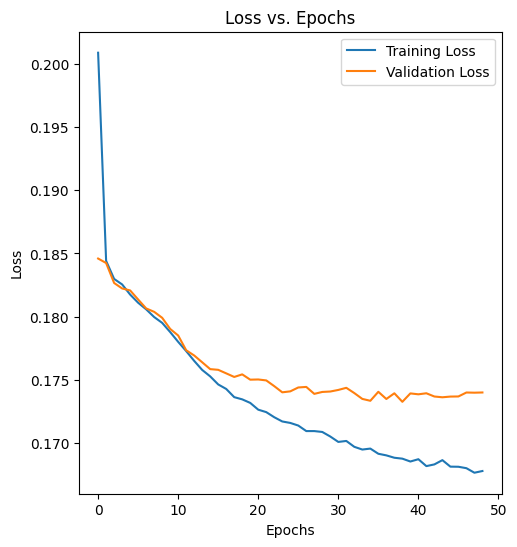

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

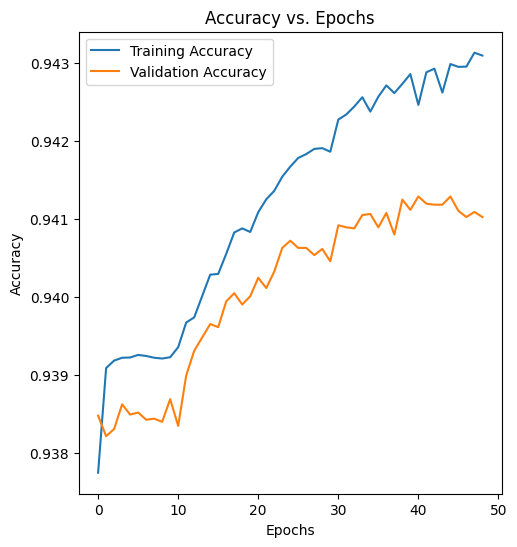

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
# Generate predictions and calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

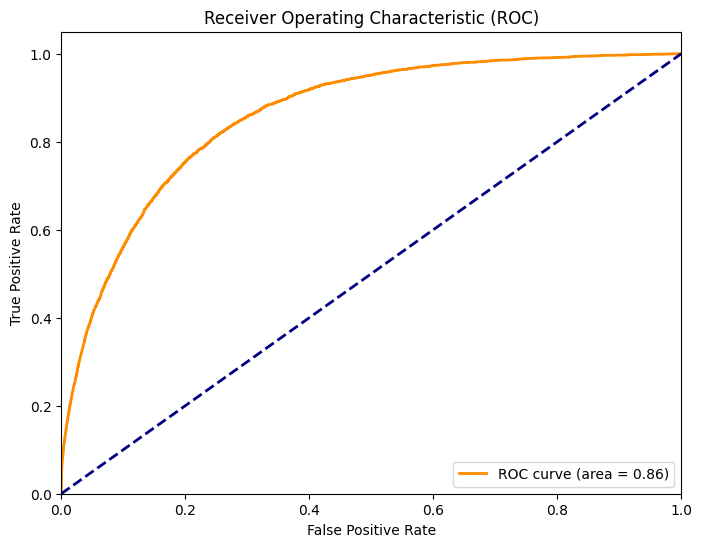

In [ ]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

The plot is a Receiver Operating Characteristic (ROC) curve, which is a graphical representation used to evaluate the performance of a binary classification model.

- The x-axis represents the False Positive Rate (FPR), which is the ratio of incorrectly classified negative instances to all actual negatives.

- The y-axis represents the True Positive Rate (TPR), also known as recall or sensitivity, which is the ratio of correctly classified positive instances to all actual positives.

- The dotted blue line represents the curve of a no-skill classifier, which is a baseline for comparison; it indicates the performance of a model that simply guesses at random.

- The solid orange line represents the ROC curve of the model being evaluated. It shows the trade-off between the TPR and FPR for different threshold settings.

- The area under the ROC curve (AUC) is a single scalar value summarizing the overall performance of the model. In this plot, the AUC is 0.86.

- An AUC of 0.86 indicates that the model has a good measure of separability, meaning it is able to distinguish between the positive and negative classes effectively.

- The closer the ROC curve is to the top left corner, the better the model's performance. In this case, the model's ROC curve is reasonably close to the top left corner, suggesting a good predictive ability.

Overall, the model corresponding to this ROC curve is considered to be performing well, as indicated by the AUC value and the shape of the ROC curve.

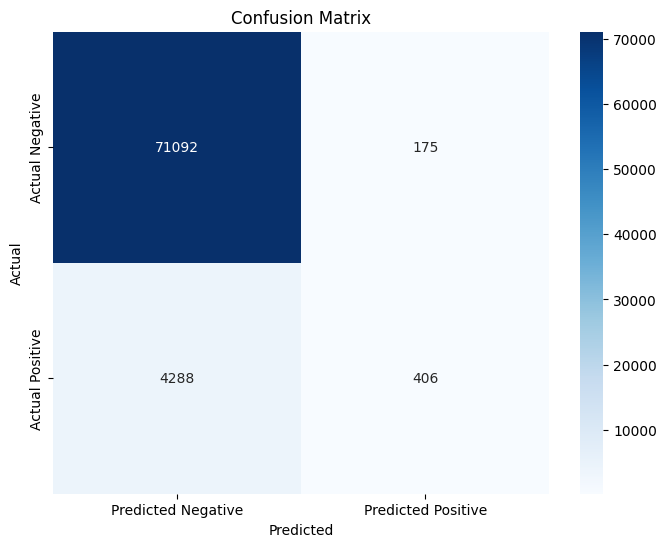

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, bin_predictions)

# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- **True Negatives (TN):**

It shows the number 71,092, which represents the true negatives, meaning that the model correctly predicted the negative class 71,092 times.

- **False Positives (FP):**

It has the number 175, indicating the false positives, which are the instances the model incorrectly predicted as positive when they were actually negative.

- **False Negatives (FN):**

It shows the number 4,288, representing the false negatives, where the model incorrectly predicted the negative class when the actual class was positive.

- **True Positives (TP):**

It has the number 406, which is the count of true positives, meaning the model correctly predicted the positive class 406 times.

Given the relatively low number of true positives (406) compared to false negatives (4,288), the model might have a low recall, indicating it struggles to identify all the positive cases. Conversely, with a small number of false positives (175), the model's precision could be quite high, indicating that when it predicts a positive result, it is likely to be correct.

However, the high number of true negatives suggests the model is effective at identifying negative cases. Overall, the model appears to be conservative in predicting positives, which could be appropriate depending on the context (e.g., in medical testing, where a false negative could be more detrimental than a false positive).

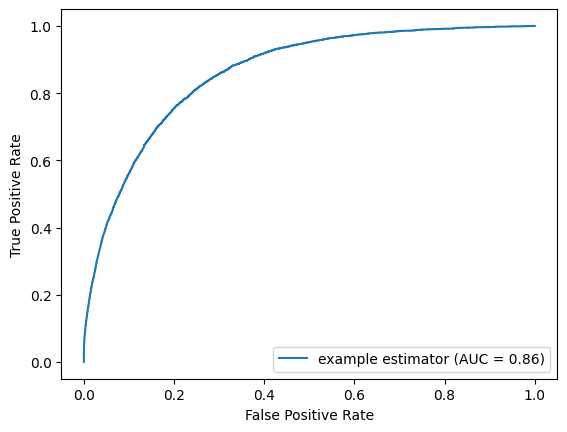

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()

# MLP Kaggle Dataset

In [ ]:
kaggle_df = pd.read_csv('datasets/heart_2020_cleaned.csv')

In [ ]:
num_var = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
cat_var = ['Smoking', 'AgeCategory', 'Race', 'Diabetic', 'GenHealth', 'Asthma']
bin_var = ['AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'KidneyDisease', 'SkinCancer', 'PhysicalActivity']
target_var = 'HeartDisease'

In [ ]:
# Label Encoding for ordinal variables
label_encoder = LabelEncoder()
for col in cat_var:
    kaggle_df[col] = label_encoder.fit_transform(kaggle_df[col])

for col in num_var:
    kaggle_df[col] = label_encoder.fit_transform(kaggle_df[col])

for col in bin_var:
    kaggle_df[col] = label_encoder.fit_transform(kaggle_df[col])

# Define a dictionary to map values
mapping = {'No': 0, 'Yes': 1}

# Apply the mapping to the column
kaggle_df['HeartDisease'] = kaggle_df['HeartDisease'].replace(mapping)

In [ ]:
kaggle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   HeartDisease      319795 non-null  int64
 1   BMI               319795 non-null  int64
 2   Smoking           319795 non-null  int64
 3   AlcoholDrinking   319795 non-null  int64
 4   Stroke            319795 non-null  int64
 5   PhysicalHealth    319795 non-null  int64
 6   MentalHealth      319795 non-null  int64
 7   DiffWalking       319795 non-null  int64
 8   Sex               319795 non-null  int64
 9   AgeCategory       319795 non-null  int64
 10  Race              319795 non-null  int64
 11  Diabetic          319795 non-null  int64
 12  PhysicalActivity  319795 non-null  int64
 13  GenHealth         319795 non-null  int64
 14  SleepTime         319795 non-null  int64
 15  Asthma            319795 non-null  int64
 16  KidneyDisease     319795 non-null  int64
 17  SkinCancer

In [ ]:
# Separate features and target
X = kaggle_df[num_var + cat_var + bin_var]
y = kaggle_df[target_var]

In [ ]:
# Preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_var),
        ('cat', OneHotEncoder(), cat_var),
        ('bin', 'passthrough', bin_var)
    ])

In [ ]:
# Preprocessing pipeline
X = preprocessor.fit_transform(X)

# Ensure the target is a numpy array
y = np.array(y)

In [ ]:
target = kaggle_df.pop('HeartDisease')
X_train, X_test, y_train, y_test = train_test_split(kaggle_df, target, test_size=0.2, random_state=42)

In [ ]:
# Normalize numerical features
scaler = StandardScaler()
X_train[num_var] = scaler.fit_transform(X_train[num_var])
X_test[num_var] = scaler.transform(X_test[num_var])

In [ ]:
feature_columns = []

# Numeric feature columns
for feature_name in num_var:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# Categorical feature columns (use one-hot encoding)
for feature_name in cat_var:
    vocabulary_list = kaggle_df[feature_name].unique()
    cat_column = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary_list)
    one_hot_column = tf.feature_column.indicator_column(cat_column)
    feature_columns.append(one_hot_column)

# Binary feature columns (use one-hot encoding)
for feature_name in bin_var:
    vocabulary_list = kaggle_df[feature_name].unique()
    bin_column = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary_list)
    one_hot_column = tf.feature_column.indicator_column(bin_column)
    feature_columns.append(one_hot_column)

In [ ]:
# Define a custom initializer with a constant value
initializer = tf.keras.initializers.Constant(0.5)

In [ ]:
# Build and compile the model with the custom initializer for a specific layer
model = tf.keras.Sequential([
        tf.keras.layers.DenseFeatures(feature_columns),
        tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer=initializer),  # Apply the initializer
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])

In [ ]:
# Add the AUC metric to the list of metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
# Convert data to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train)).batch(32)
eval_ds = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test)).batch(32)

In [ ]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)

In [ ]:
# Train the model
history = model.fit(train_ds, validation_data=eval_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100


7995/7995 [==============================] - 16s 2ms/step - loss: 0.2560 - accuracy: 0.9122 - auc_3: 0.7776 - val_loss: 0.2349 - val_accuracy: 0.9130 - val_auc_3: 0.8365
Epoch 2/100
7995/7995 [==============================] - 16s 2ms/step - loss: 0.2286 - accuracy: 0.9160 - auc_3: 0.8340 - val_loss: 0.2320 - val_accuracy: 0.9136 - val_auc_3: 0.8376
Epoch 3/100
7995/7995 [==============================] - 16s 2ms/step - loss: 0.2271 - accuracy: 0.9162 - auc_3: 0.8373 - val_loss: 0.2312 - val_accuracy: 0.9139 - val_auc_3: 0.8377
Epoch 4/100
7995/7995 [==============================] - 16s 2ms/step - loss: 0.2265 - accuracy: 0.9162 - auc_3: 0.8387 - val_loss: 0.2311 - val_accuracy: 0.9138 - val_auc_3: 0.8381
Epoch 5/100
7995/7995 [==============================] - 15s 2ms/step - loss: 0.2260 - accuracy: 0.9165 - auc_3: 0.8396 - val_loss: 0.2310 - val_accuracy: 0.9137 - val_auc_3: 0.8382
Epoch 6/100
7995/7995 [==============================] - 15s 2ms/step - loss: 0.2256 - accuracy: 0.916

In [ ]:
# Evaluate the model
predictions = model.predict(eval_ds)
bin_predictions = [1 if p > 0.5 else 0 for p in predictions]
# Generate classification report
print(classification_report(y_test, bin_predictions))

1999/1999 [==============================] - 3s 1ms/step
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.53      0.10      0.17      5592

    accuracy                           0.91     63959
   macro avg       0.72      0.55      0.56     63959
weighted avg       0.89      0.91      0.89     63959



**Class 0 (Negative Class):**

- Precision: 0.92, indicating a high likelihood that a predicted negative is truly negative.

- Recall: 0.99, suggesting that the model is very good at identifying actual negatives.

- F1-Score: 0.95, showing a strong balance between precision and recall for the negative class.

- Support: 58,367, indicating the number of actual occurrences of the negative class in the dataset.

**Class 1 (Positive Class):**

- Precision: 0.53, meaning that when the model predicts positive, it is correct about 53% of the time.

- Recall: 0.10, indicating that the model identifies 10% of all actual positives correctly.

- F1-Score: 0.17, reflecting a poor balance between precision and recall for the positive class.

- Support: 5,592, which is the number of actual occurrences of the positive class in the dataset.

**Overall Metrics:**

- Accuracy: 0.91, showing that the model correctly predicts the class (whether positive or negative) 91% of the time.

- Macro Average: Averages the precision, recall, and f1-score without considering the class imbalance:

  - Precision: 0.72
  - Recall: 0.55
  - F1-Score: 0.56
  
- Weighted Average: Averages the precision, recall, and f1-score, taking into account the support of each class:

  - Precision: 0.89
  - Recall: 0.91
  - F1-Score: 0.89

The high accuracy might be misleading because the model performs very well for the negative class but poorly for the positive class. This discrepancy is reflected in the macro averages, which are significantly lower than the weighted averages due to the class imbalance. The model appears to have a significant bias towards predicting the negative class, which is common in datasets where one class predominates. This can be problematic if the cost of false negatives is high, such as in fraud detection or disease diagnosis.

In [ ]:
# Calculate AUC score
print("AUC Score: ", '{0:.2%}'.format(roc_auc_score(y_test, predictions)))
print(model.summary())

AUC Score:  84.09%
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features_3 (DenseFea  multiple                  0         
 tures)                                                          
                                                                 
 dense_9 (Dense)             multiple                  6528      
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dense_10 (Dense)            multiple                  16512     
                                                                 
 dense_11 (Dense)            multiple                  129       
                                                                 
Total params: 23169 (90.50 KB)
Trainable params: 23169 (90.50 KB)
Non-trainable params: 0 (0.00 Byte)

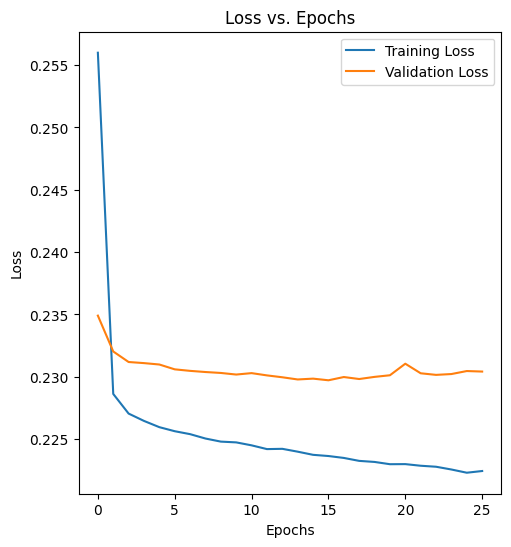

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

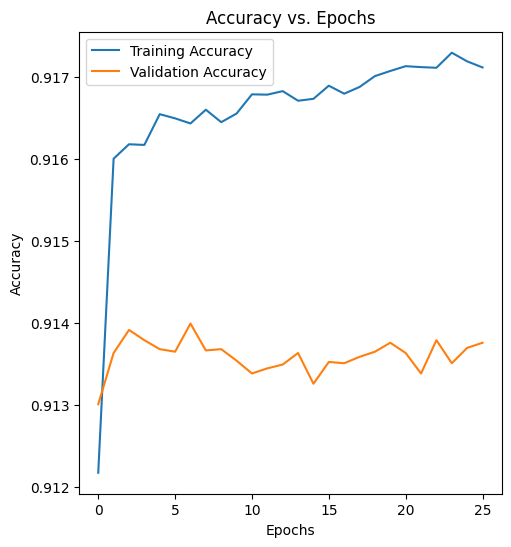

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
# Generate predictions and calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

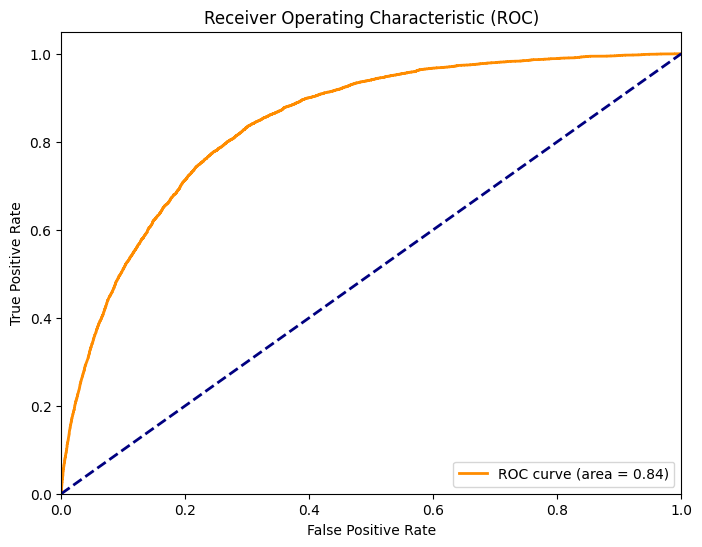

In [ ]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

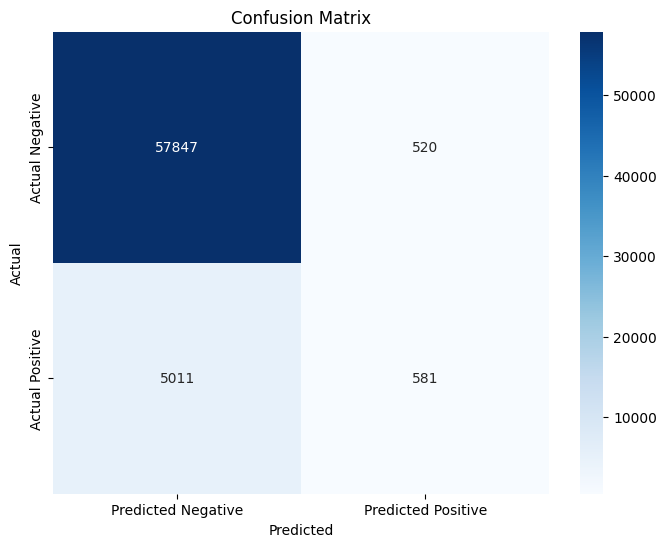

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, bin_predictions)

# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- **True Negatives (TN):** 57,847 instances were correctly predicted as negative.

- **False Positives (FP):** 520 instances were incorrectly predicted as positive when they were actually negative.

- **False Negatives (FN):** 5,011 instances were incorrectly predicted as negative when they were actually positive.

- **True Positives (TP):** 581 instances were correctly predicted as positive.

This confusion matrix indicates a model with a high number of true negatives and a significant number of false negatives. This suggests that the model may have a high specificity (it's good at identifying negatives), but lower sensitivity (it's not as good at identifying positives). This could imply a cautious prediction model that prefers to predict negative outcomes unless it has strong evidence for a positive one. The relatively low number of true positives compared to false negatives also suggests that the model might struggle with identifying the positive class, which could be a concern depending on the application. For instance, in a medical diagnosis context, a high number of false negatives could be very risky.

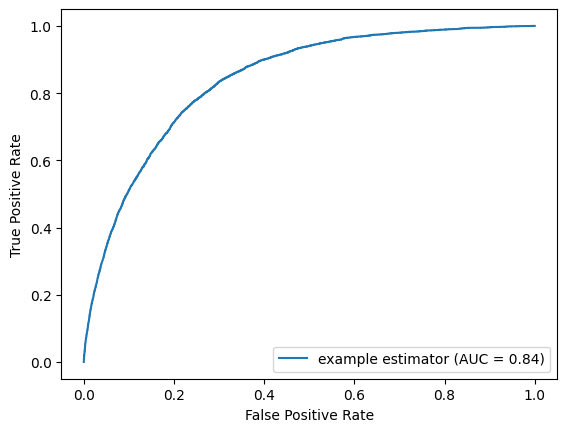

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()

# AutoEncoder

Autoencoders are a special kind of neural network utilized for unsupervised machine learning tasks, particularly those involving dimensionality reduction and anomaly detection. Here are the core aspects of autoencoders, synthesized from multiple sources:

- Basic Functionality:
An autoencoder is designed to learn to copy its input to its output through a compressed representation. It first encodes the input into a lower-dimensional latent space, and then decodes this representation back to the original input format​​.

- Architecture:
The architecture comprises three main parts: the encoder, the code, and the decoder. The encoder compresses the input data to form a code, the decoder then reconstructs the original data from this code​.

- Learning Method:
Autoencoders learn data encodings in an unsupervised manner, meaning they don't require labeled data for training. They aim to learn a lower-dimensional representation of higher-dimensional data, and are trained to capture the most significant features of the input data​​.

- Use Cases:
They are widely used for dimensionality reduction, noise reduction, generating new data that's similar to the training data (generative modeling), and detecting anomalies in data.

- Limitations:
There are limitations associated with autoencoders, such as the risk of learning too simple a function (the identity function) when the capacity of the network is too high.

<img src='Images/ae.png' width=800 align="center">

# AutoEncoder IMPUTED dataset

**tf.boolean_mask** is a function in TensorFlow that selects elements from a tensor based on the values of a boolean mask tensor.

It takes two primary arguments:

A tensor you want to filter.
A boolean mask tensor of the same shape (or a shape that is broadcastable) as the first tensor, which determines which elements to select.

For every position where the mask tensor has the value True, tf.boolean_mask will take the corresponding element from the tensor you want to filter. For positions where the mask tensor has the value False, the corresponding element will not be included in the output.

In [ ]:
df = pd.read_csv("/content/numerical_data_imputed.csv")

In [ ]:
# Split the data into features (X) and labels (y)
X = df.drop('HeartDisease', axis=1).values
y = df['HeartDisease'].values

In [ ]:
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_train_bool = tf.cast(y_train, dtype=tf.bool)
y_test_bool = tf.cast(y_test, dtype=tf.bool)

In [ ]:
#creating normal and diseased datasets
normal_train_data = tf.boolean_mask(X_train, ~y_train_bool)
normal_test_data = tf.boolean_mask(X_test, ~y_test_bool)
diseased_train_data = tf.boolean_mask(X_train, y_train_bool)
diseased_test_data = tf.boolean_mask(X_test, y_test_bool)

In [ ]:
print("Records in Diseased Train Data = ",len(diseased_train_data))
print("Records in Normal Train Data = ",len(normal_train_data))
print("Records in Diseased Test Data = ",len(diseased_test_data))
print("Records in Normal Test Data=",len(normal_test_data))

Records in Diseased Train Data =  18496
Records in Normal Train Data =  285345
Records in Diseased Test Data =  4723
Records in Normal Test Data= 71238


In [ ]:
features = X_test.shape[-1] #Whole of features

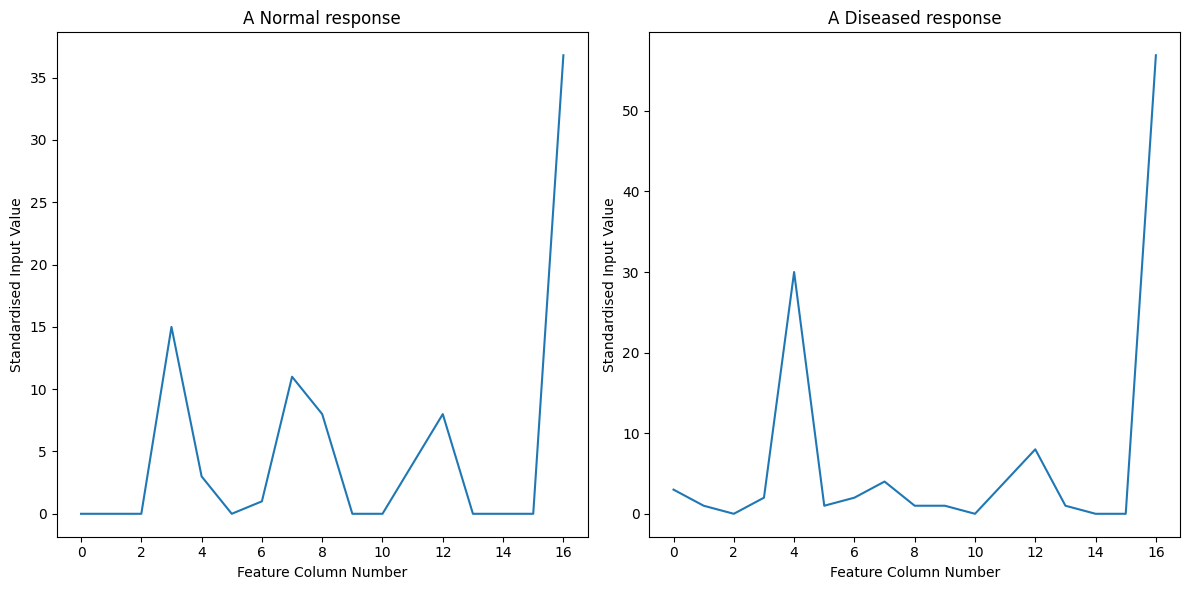

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].plot(np.arange(features), normal_train_data[0])
ax[0].set_xlabel("Feature Column Number")
ax[0].set_ylabel("Standardised Input Value")
ax[0].set_title("A Normal response")

ax[1].plot(np.arange(features), diseased_train_data[0])
ax[1].set_title("A Diseased response")
ax[1].set_xlabel("Feature Column Number")
ax[1].set_ylabel("Standardised Input Value")

plt.tight_layout()
plt.show()

**A Normal Response Plot:**

This plot shows the values of all the features for the first instance (i.e., the first row) in the normal_train_data.

The x-axis represents the feature column numbers, i.e., each individual feature or attribute of the data.

The y-axis represents the standardized values of those features for the first "normal" instance in the training data. Standardization typically means that the values have been scaled to have a mean of 0 and a standard deviation of 1.

**A Diseased Response Plot:**

Similarly, this plot shows the values of all the features for the first instance in the diseased_train_data.

Again, the x-axis denotes the feature column numbers, and the y-axis represents the standardized values of those features.

**Normal Response:**

The plot representing a "Normal response" shows a series of standardized input values across 17 feature columns. The data points exhibit a relatively stable pattern with moderate fluctuations in value. Notably, there is a peak at feature column 14 where the value rises sharply above 20, suggesting a significant but isolated input value in the context of this set.

**Diseased Response:**

In contrast, the "Diseased response" plot indicates more dramatic fluctuations with pronounced peaks. The most notable peak is at feature column 4, nearing a value of 30, and another significant rise at feature column 14. These marked increases suggest a strong deviation in input values when the disease is present, indicating that these features might be highly affected by or indicative of the disease.

**Comparison:**

Comparing the two plots, it is evident that the diseased state is characterized by heightened peaks in certain feature columns, particularly column 4 and 14, which stand out against the more subdued peaks in the normal state. This comparison suggests that the disease state can be distinguished by these aberrant peaks in the data.

**Conclusion:**

The disparity in feature values between the normal and diseased states suggests a potential avenue for diagnostic classification. These differences might reflect underlying biological or pathological processes that are amplified or altered by the disease. A machine learning model could potentially exploit these differences to classify or predict the disease state. However, further analysis would be required to ascertain the statistical significance and the biological relevance of these feature columns to the disease in question. This analysis underscores the potential of using such standardized input values as biomarkers or diagnostic indicators in the context of the disease studied.

In [ ]:
autoencoder = Autoencoder(features)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=20, mode='min', restore_best_weights=True)

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data, epochs=100, batch_size=256, shuffle=True, validation_split = 0.2, callbacks=[early_stopping]).history

Epoch 1/100
892/892 [==============================] - 9s 5ms/step - loss: 7.8225 - accuracy: 0.8611 - val_loss: 1.2127 - val_accuracy: 0.9707
Epoch 2/100
892/892 [==============================] - 5s 6ms/step - loss: 0.7862 - accuracy: 0.9683 - val_loss: 0.7421 - val_accuracy: 0.9472
Epoch 3/100
892/892 [==============================] - 4s 5ms/step - loss: 0.6443 - accuracy: 0.9687 - val_loss: 0.4268 - val_accuracy: 0.9482
Epoch 4/100
892/892 [==============================] - 4s 5ms/step - loss: 0.4049 - accuracy: 0.9712 - val_loss: 0.3812 - val_accuracy: 0.9949
Epoch 5/100
892/892 [==============================] - 5s 6ms/step - loss: 0.3500 - accuracy: 0.9703 - val_loss: 0.3300 - val_accuracy: 0.9530
Epoch 6/100
892/892 [==============================] - 4s 5ms/step - loss: 0.3104 - accuracy: 0.9701 - val_loss: 0.3071 - val_accuracy: 0.9421
Epoch 7/100
892/892 [==============================] - 5s 5ms/step - loss: 0.2993 - accuracy: 0.9696 - val_loss: 0.3002 - val_accuracy: 0.9889

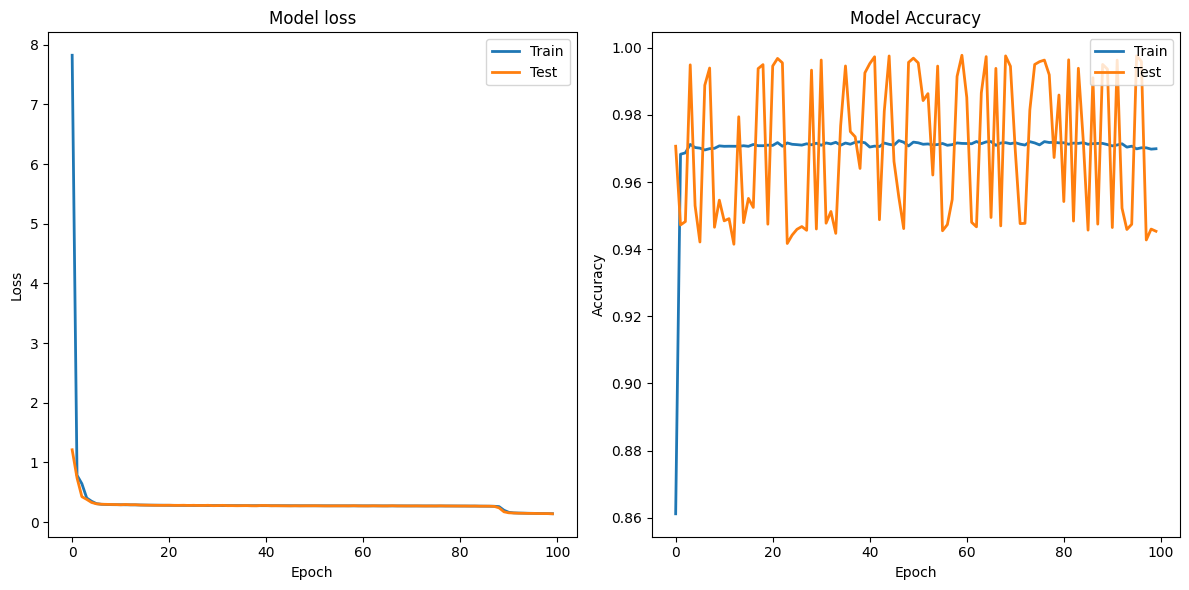

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].plot(history['loss'], linewidth=2, label='Train')
ax[0].plot(history['val_loss'], linewidth=2, label='Test')
ax[0].legend(loc='upper right')
ax[0].set_title('Model loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')


ax[1].plot(history['accuracy'], linewidth=2, label='Train')
ax[1].plot(history['val_accuracy'], linewidth=2, label='Test')
ax[1].legend(loc='upper right')
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

**Model Loss:**

The 'Model Loss' plot demonstrates a sharp decrease in loss for both the training (blue line) and testing (orange line) datasets as the number of epochs increases. The initial loss values start quite high but rapidly descend, indicating that the model is quickly learning from the data. The loss for both datasets seems to converge as the number of epochs increases, suggesting that the model is stabilizing and generalizing well without overfitting, as the test loss is decreasing in tandem with the training loss and both are plateauing at a similar rate after around 20 epochs.

**Model Accuracy:**

The 'Model Accuracy' plot shows a rapid increase in accuracy during the initial epochs for both the training and testing datasets. The training accuracy (blue line) appears to plateau close to 1.0 (or 100%), which suggests that the model is nearly perfectly fitting the training data. The testing accuracy (orange line) also increases similarly and oscillates slightly above and below the training accuracy, indicating the model is performing well on the unseen data as well. Notably, the testing accuracy does not significantly diverge from the training accuracy, which would typically be a sign of overfitting.

**Comparison and Conclusion:**

The congruence of the training and testing lines in both plots indicates that the model has achieved a good balance between learning the underlying patterns in the data and generalizing to new, unseen data. There are no significant signs of overfitting or underfitting, as evidenced by the consistent decrease in loss and the high level of accuracy that is maintained throughout the testing phase.

In conclusion, the performance metrics suggest that the model has been trained effectively, with both high accuracy and low loss in both training and testing phases. The model seems to generalize well to new data, which is essential for reliable predictions in practical applications. Moving forward, maintaining such balance will be critical as the model is further developed or deployed.

In [ ]:
# Normal Train Loss
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

8918/8918 [==============================] - 16s 2ms/step


In [ ]:
# Normal Test Loss
reconstructions_test = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions_test, X_test)

2374/2374 [==============================] - 4s 2ms/step


In [ ]:
# Normal Threshold
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold for anomaly detection: ", round(threshold,3))

Threshold for anomaly detection:  0.296


**Anomaly Score:**

The model would compute some kind of anomaly score for each data point in the dataset. This score would quantify how much of an outlier the data point is in comparison to the rest of the data. The score could be based on a variety of metrics, such as reconstruction error in autoencoders.

**Threshold Application:**

The threshold of 0.296 acts as a cutoff value. Scores above this threshold would indicate an anomaly, while scores below would suggest normal behavior. The specific choice of threshold is crucial and would depend on the domain and the cost of false positives (normal behavior wrongly identified as an anomaly) versus false negatives (anomalies not detected).

**Anomaly Detection:**

For each new observation, the model would generate an anomaly score based on the learned patterns during training. If the score is higher than the threshold, the observation would be flagged as an anomaly.

**Model Performance:**

The chosen threshold would significantly affect the model's performance. It's a balance between sensitivity (the ability to detect true anomalies) and specificity (the ability to not flag normal data as anomalous). The optimal threshold is usually determined by evaluating the model on a validation set and considering the trade-off between false positives and false negatives.

<img src='Images/entropy.png'>

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

In [ ]:
encoded_diseased_data = autoencoder.encoder(diseased_test_data).numpy()
decoded_diseased_data = autoencoder.decoder(encoded_diseased_data).numpy()

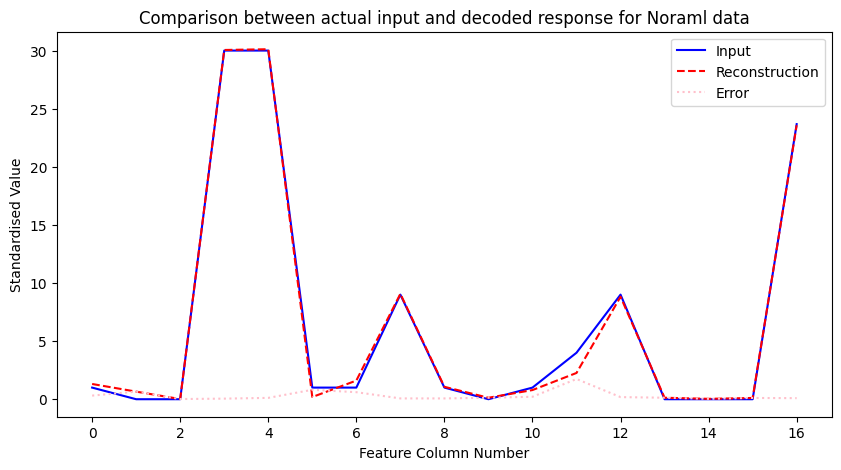

In [ ]:
# Plot comparison for a random sample from the test set
plot_comparison(normal_test_data, decoded_data, text='Noraml')

**Input:**

This represents the original data that was fed into the model. It serves as the benchmark for assessing the model's ability to reconstruct or predict the normal data after training.

**Reconstruction:**

This line shows the data after it has been processed by the model. In the context of an autoencoder, this would be the output from the decoder part, which attempts to recreate the original input from the encoded representation.

**Error:**

The dotted line represents the error, which is the difference between the input and the reconstruction. The error metric is crucial for model evaluation; low errors indicate that the model can accurately reconstruct the input, suggesting good learning and generalization.

The reconstruction closely follows the pattern of the input data, indicating that the model has learned the underlying structure well.
The error for most of the feature columns is relatively low, which further confirms the model's good performance on normal data.
There are small peaks in error at certain feature columns, but they do not seem to be significantly high, which is expected in a normally functioning model.
This kind of visualization is helpful in understanding and diagnosing the model's performance, as it can highlight which features the model struggles to reconstruct accurately, potentially guiding further fine-tuning or investigation. If this plot were for anomalous data, we might expect to see larger discrepancies between the input and reconstruction, resulting in more significant error spikes.

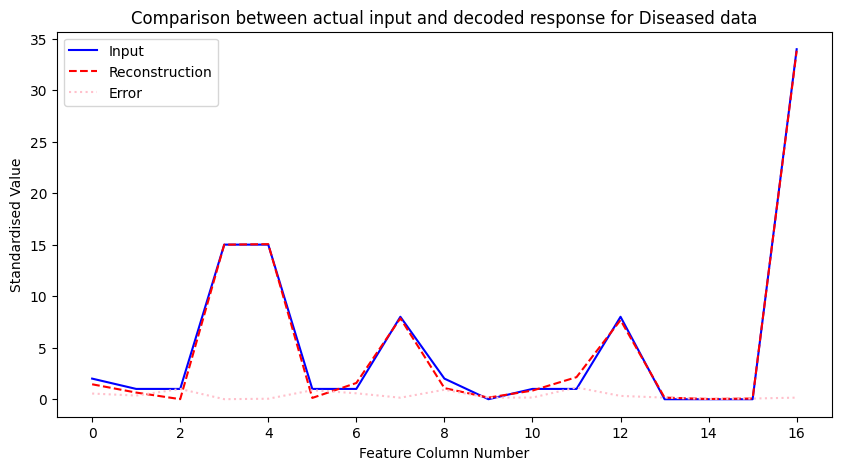

In [ ]:
# compariosn plot for decoded data
plot_comparison(diseased_test_data, decoded_diseased_data, text='Diseased')

There are visible discrepancies between the input and the reconstructed data, most notably around feature columns 4-6 and 8-14, suggesting that these features exhibit behavior that is not typical of the normal data the model has learned to reconstruct.
The error spikes are more pronounced than those in the plot for normal data, which aligns with the expectation that the model will have a harder time accurately reconstructing diseased data.
The pattern of errors could be indicative of the specific ways in which diseased data differs from normal data, which can be valuable for diagnostic purposes.

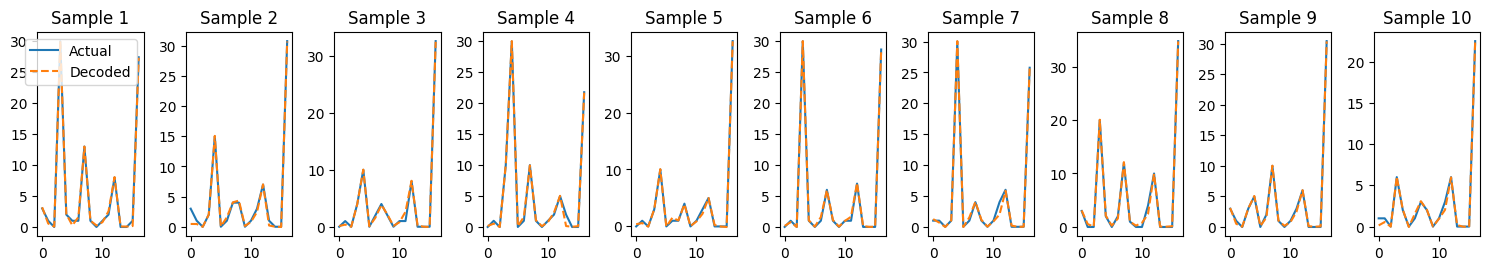

In [ ]:
# Plot actual vs decoded for a few samples from the test set
plot_actual_vs_decoded(normal_test_data, decoded_data)

**Actual:** This shows the actual data points for each sample.

**Decoded:** This depicts the reconstructed data points after being processed by a decoding model.

**Observations:**

The overall trends and patterns in the decoded (dashed orange) line closely follow those of the actual (solid blue) line in all samples, indicating a good reconstruction performance by the model across different scenarios.
Despite the general alignment, there are some variations between the actual and decoded values, noticeable in the peaks and troughs of the lines. These discrepancies are natural in a reconstruction scenario, especially with complex or noisy data.
No single subplot shows a consistently large deviation between the actual and decoded lines, suggesting that the model has not systematically failed on any one sample.


**Conclusions:**

The model exhibits a robust ability to reconstruct various inputs, as indicated by the close correspondence between the actual and decoded lines across different samples.
There are no extreme anomalies or errors in the reconstruction, which implies the model generalizes well across the samples shown.
This consistent performance across multiple samples suggests the model is well-trained and reliable for the data and task it has been designed for.

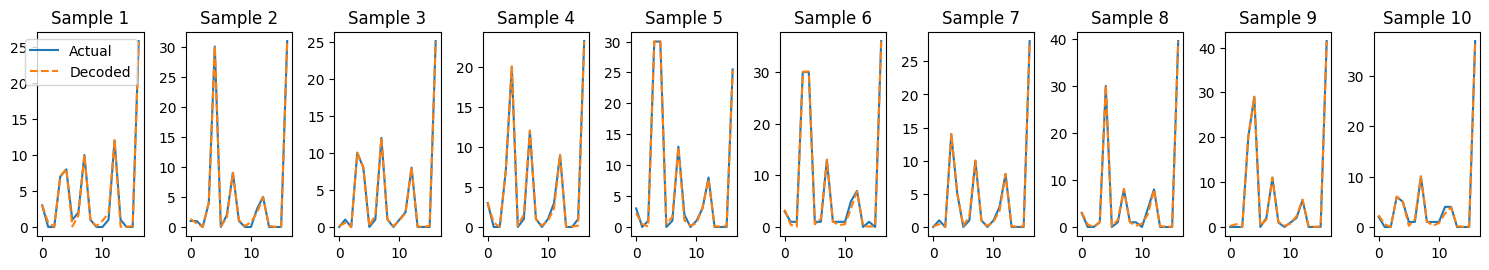

In [ ]:
# Plot actual vs decoded for a few samples from the diseased test set
plot_actual_vs_decoded(diseased_test_data, decoded_diseased_data)

They show a good match between the actual and decoded data, indicating that the model used for decoding is performing well at reconstructing the data across these various samples.

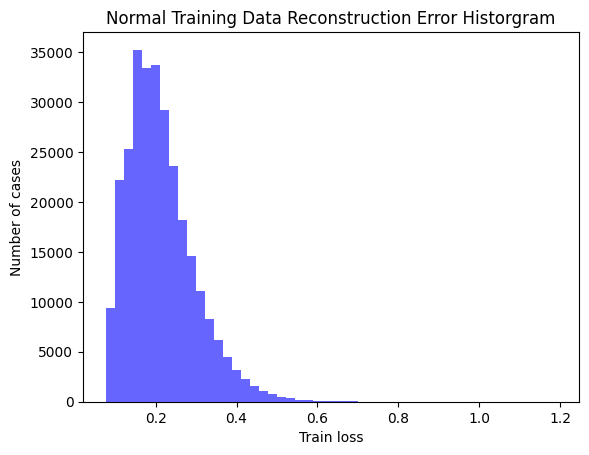

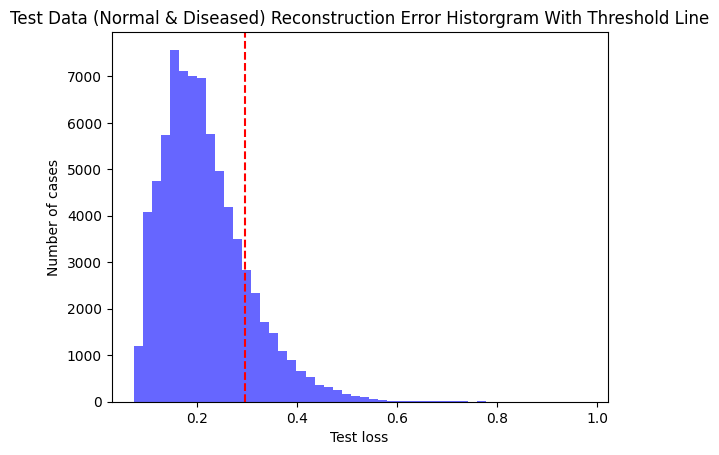

In [ ]:
plot_reconstruction_error(normal_train_data, X_test, train_loss, test_loss, threshold)

**Normal Training Data Reconstruction Error Histogram:**

This histogram represents the distribution of reconstruction errors (train loss) on your normal training data. The x-axis indicates the magnitude of the train loss, and the y-axis represents the number of cases with that loss.
The plot shows that the majority of your normal training data has a very low reconstruction error, which is typical for normal behavior in an anomaly detection setting. Most of the data is concentrated towards the left side of the histogram (near zero), suggesting that the model is reconstructing the normal data with low error.

**Test Data Reconstruction Error Histogram With Threshold Line:**

This histogram shows the distribution of reconstruction errors (test loss) for your test dataset, which includes both normal and diseased (anomalous) data. The dashed red line represents the threshold for anomaly detection.
In this histogram, the x-axis shows the test loss, and the y-axis shows the frequency of cases for each loss value.
The placement of the threshold line (around 0.296, as we've previously mentioned) is critical. It determines the cutoff point between normal and anomalous data points. Cases to the left of the line are considered normal, while those to the right are considered potential anomalies.

The histogram demonstrates a bimodal distribution, with a significant number of cases having higher errors (to the right of the threshold line), which could be potential anomalies. The distribution of errors on the test data is broader compared to the training data, which is expected since it includes diseased data likely to have a higher reconstruction error.

Based on these plots, it's evident that your model is able to differentiate between normal and anomalous cases to some extent, as there's a clear distinction in the distribution of reconstruction errors. The threshold line seems to be at an appropriate level where a considerable number of anomalies can be detected while keeping false positives low. However, to fully evaluate the effectiveness of this threshold, one would also need to consider the context of the application, the acceptable rates of false positives/negatives, and potentially other metrics such as precision, recall, and the F1 score.

**Evaluate the Model on the Test Set**

If loss represents the reconstruction error of each data point,
and if points with a higher reconstruction error than the threshold are considered anomalies,
Then preds will be True for anomalies and False otherwise.

In [ ]:
reconstructions = autoencoder.predict(X_test)
loss = tf.keras.losses.mae(reconstructions, X_test)
preds = tf.math.greater(loss, threshold) # creates a tensor of boolean values
preds_int = tf.cast(preds, dtype=tf.int32).numpy() # Convert boolean tensor to integers

2374/2374 [==============================] - 4s 2ms/step


In [ ]:
# Generate the confusion matrix
matrix = confusion_matrix(y_test, preds_int)

In [ ]:
print(matrix)

[[60665 10573]
 [ 2892  1831]]


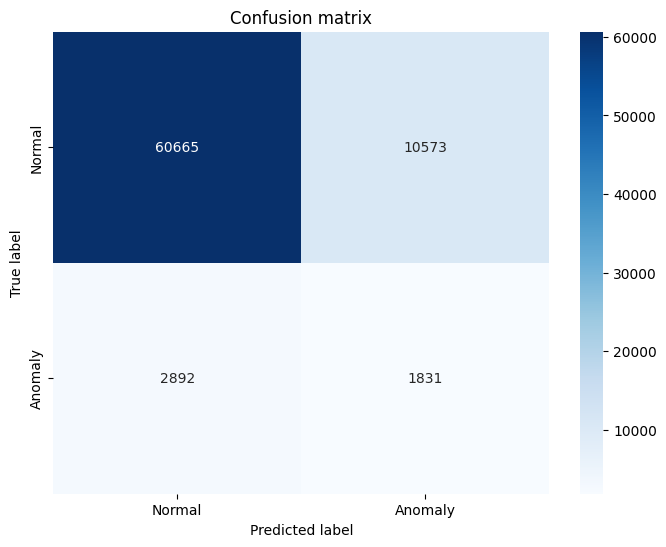

In [ ]:
plot_confusion_matrix(y_test, preds_int, classes=['Normal', 'Anomaly'])

**True Positive (TP):** 60665 cases were normal and correctly identified as normal.

**False Negative (FN):** 10573 cases were normal but incorrectly identified as anomalies.

**False Positive (FP):** 2892 cases were anomalies but incorrectly identified as normal.

**True Negative (TN):** 1831 cases were anomalies and correctly identified as such.

These values show the model is quite good at identifying normal cases (high TP), it struggles with a significant number of false negatives, indicating that normal cases are often misclassified as anomalies. It also has a considerable number of false positives, where anomalous cases are missed and labeled as normal.


In [ ]:
print(classification_report(y_test, preds_int))

              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90     71238
         1.0       0.15      0.39      0.21      4723

    accuracy                           0.82     75961
   macro avg       0.55      0.62      0.56     75961
weighted avg       0.90      0.82      0.86     75961



**Precision:**

The ability of the classifier not to label as positive a sample that is negative.
For normal cases, precision is perfect, which is typically the case when the "normal" class dominates.
For anomalies, precision is low at 0.15, which means that when the model predicts an anomaly, it is correct only 15% of the time.

**Recall:**

The ability of the classifier to find all the positive samples.
The recall for normal cases is very high at 0.85, suggesting the model is adept at identifying most of the normal cases.
For anomalies, the recall is quite low at 0.39, indicating that the model only finds 30% of all actual anomalies.

**F1-Score:**

A weighted harmonic mean of precision and recall. The best value is 1 and the worst is 0.
The F1-score for normal cases is high at 0.90 due to the high precision and recall.
The F1-score for anomalies is low at 0.21, reflecting the poor precision and recall for this class.

**Support:**

The number of actual occurrences of the class in the dataset.
There are 71238 normal cases and 4723 anomalous cases.

**Accuracy:**

This is the ratio of correct predictions to the total number of cases. At 0.82, it indicates that overall, 82% of the predictions made by the model are correct.

**Macro Average:**

Averages the unweighted mean per label, which is not very high, reflecting the imbalance in performance between the two classes.

**Weighted Average:**

Averages the support-weighted mean per label, which is better due to the high support for the normal class.

The model's overall accuracy might seem high at first glance; however, the critical evaluation for anomaly detection should focus on the model's ability to correctly identify anomalies, which is not as strong. In this context, the low recall (0.30) for anomalies is particularly concerning because it implies that 70% of anomalies could go undetected, which can be critical depending on the application (e.g., fraud detection, disease detection, system failure prediction).

The high number of false positives also affects the precision for anomaly detection, making it unreliable in its current state for cases where the consequences of missing an anomaly are severe. The model would benefit from further tuning and possibly from incorporating additional features or utilizing different modeling techniques to improve its anomaly detection capabilities.

In [ ]:
errors_test = np.mean(np.square(reconstructions_test - X_test), axis=1)

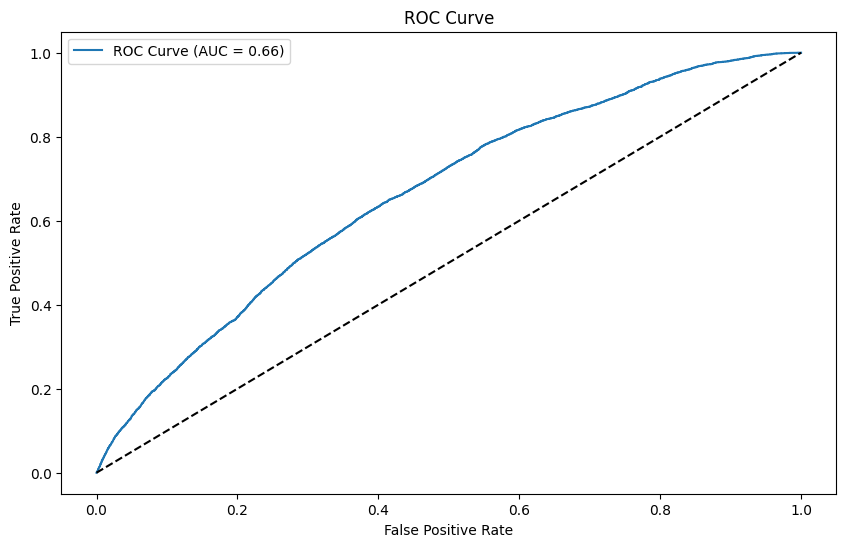

In [ ]:
roc_score = roc_auc_score(y_test, errors_test)
fpr, tpr, thresholds = roc_curve(y_test, errors_test)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_score:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

**ROC Curve:**

The ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
The curve is created by plotting the True Positive Rate (TPR, or recall) against the False Positive Rate (FPR) at various threshold settings.

**AUC - Area Under the Curve:**

The AUC provides a single measure of overall performance of the classifier. It ranges from 0 to 1, where 0.5 represents a model that does no better than random chance and 1 represents a perfect model.
An AUC of 0.66 means that the model has a 66% chance of correctly distinguishing between the classes (normal and anomaly in this case). This is better than a random guess, but not by a wide margin.

**Interpretation of This ROC Curve:**

The curve stays relatively close to the diagonal line, which represents the performance of a random classifier. A perfect classifier would have a line that goes straight up the y-axis and then across to the right at the top.
The fact that the ROC curve is above the diagonal line indicates that the classifier does have the ability to discriminate between the positive and negative class, but it's not very strong.
Given that the AUC is 0.66, it can be concluded that the performance is somewhat better than chance, but still far from ideal. This aligns with the earlier metrics from the confusion matrix and classification report indicating that while the model has a decent rate of identifying normal cases, it is not very effective at identifying anomalies.
Improving this model could involve several steps, such as collecting more balanced data, feature engineering, trying different algorithms, or tuning hyperparameters to increase the true positive rate without raising the false positive rate too much.

# AutoEncoder OverSampling IMPUTED Dataset

In [ ]:
over = RandomOverSampler(random_state=42)

In [ ]:
x_new , y_new = over.fit_resample(X,y)
xtrain, xtest, ytrain, ytest = train_test_split(x_new, y_new, train_size=.70,random_state=42)

In [ ]:
ytrain = ytrain.astype(bool)
ytest = ytest.astype(bool)

In [ ]:
#creating normal and diseased datasets
normal_train_data_os = tf.boolean_mask(xtrain, ~ytrain)
normal_test_data_os = tf.boolean_mask(xtest, ~ytest)
diseased_train_data_os = tf.boolean_mask(xtrain, ytrain)
diseased_test_data_os = tf.boolean_mask(xtest, ytest)

In [ ]:
print("Records in Diseased Train Data = ",len(diseased_train_data_os))
print("Records in Normal Train Data = ",len(normal_train_data_os))
print("Records in Diseased Test Data = ",len(diseased_test_data_os))
print("Records in Normal Test Data=",len(normal_test_data_os))

Records in Diseased Train Data =  249596
Records in Normal Train Data =  249620
Records in Diseased Test Data =  106987
Records in Normal Test Data= 106963


In [ ]:
over_features = xtest.shape[-1] #Whole of features

In [ ]:
autoencoder = Autoencoder(over_features)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=20, mode='min', restore_best_weights=True)

In [ ]:
history = autoencoder.fit(xtrain, xtrain, epochs=200, batch_size=256, shuffle=True, validation_split = 0.2, callbacks=[early_stopping]).history

Epoch 1/200
1561/1561 [==============================] - 11s 6ms/step - loss: 6.5940 - accuracy: 0.8703 - val_loss: 0.4973 - val_accuracy: 0.9310
Epoch 2/200
1561/1561 [==============================] - 8s 5ms/step - loss: 0.3266 - accuracy: 0.9595 - val_loss: 0.2686 - val_accuracy: 0.9287
Epoch 3/200
1561/1561 [==============================] - 8s 5ms/step - loss: 0.2466 - accuracy: 0.9598 - val_loss: 0.2135 - val_accuracy: 0.9947
Epoch 4/200
1561/1561 [==============================] - 8s 5ms/step - loss: 0.1773 - accuracy: 0.9602 - val_loss: 0.1638 - val_accuracy: 0.9975
Epoch 5/200
1561/1561 [==============================] - 8s 5ms/step - loss: 0.1569 - accuracy: 0.9614 - val_loss: 0.1603 - val_accuracy: 0.9308
Epoch 6/200
1561/1561 [==============================] - 8s 5ms/step - loss: 0.1554 - accuracy: 0.9616 - val_loss: 0.1598 - val_accuracy: 0.9286
Epoch 7/200
1561/1561 [==============================] - 8s 5ms/step - loss: 0.1547 - accuracy: 0.9621 - val_loss: 0.1616 - val_a

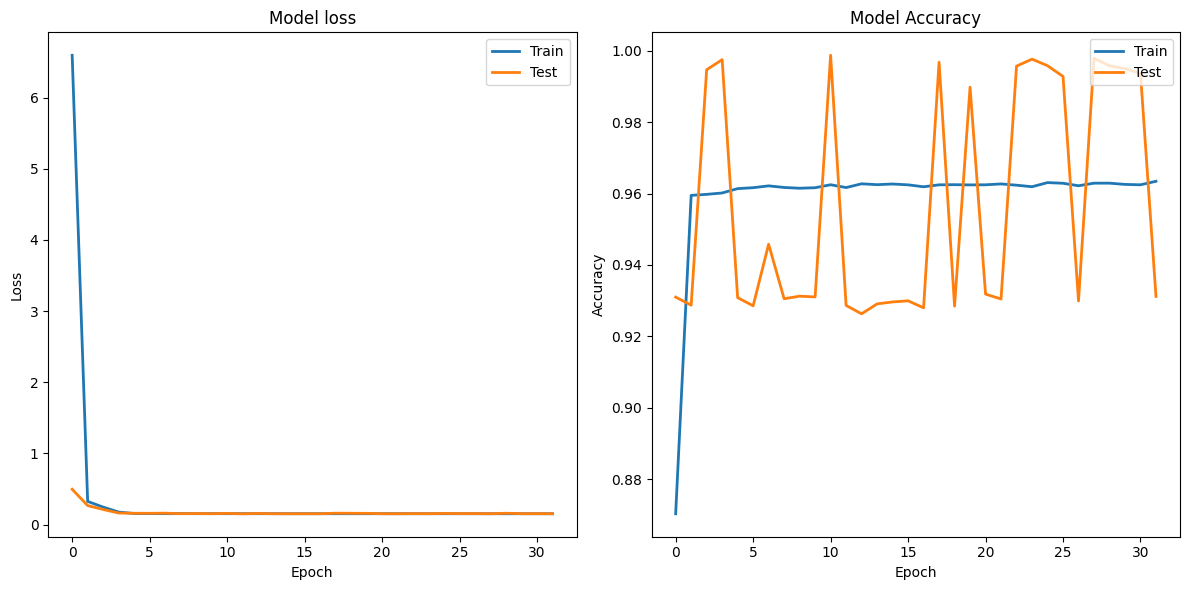

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].plot(history['loss'], linewidth=2, label='Train')
ax[0].plot(history['val_loss'], linewidth=2, label='Test')
ax[0].legend(loc='upper right')
ax[0].set_title('Model loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')


ax[1].plot(history['accuracy'], linewidth=2, label='Train')
ax[1].plot(history['val_accuracy'], linewidth=2, label='Test')
ax[1].legend(loc='upper right')
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

**Model Loss:**

The loss on both the training and test sets decreases sharply in the initial epochs, suggesting that the model is learning and improving rapidly from its initial state.
After the initial sharp decrease, the loss curves flatten out, indicating that as epochs increase, the rate of improvement in loss reduction diminishes.
The convergence of training and test loss suggests that the model is generalizing well to unseen data. There is no sign of divergence, which would indicate overfitting.

**Model Accuracy:**

The accuracy for both training and test sets increases sharply initially and then exhibits fluctuations throughout the remaining epochs.
The training accuracy appears to be slightly higher than the test accuracy for most of the training process, which is a normal behavior as the model has direct access to the training data.
The fluctuations and the close convergence of the lines suggest that the model is not overfitting significantly, which is good. It’s maintaining its performance on the test set quite well throughout the training process.
The accuracy appears to be very high, generally above 95%, which is excellent. However, the effectiveness of the model should still be validated for practical use, especially considering that accuracy might not be the best metric if the original data was imbalanced.

**Observations Regarding Oversampling:**

The high accuracy and good generalization could partly be attributed to the application of oversampling techniques, which aim to balance class distributions and provide the model with a more representative learning environment.
Oversampling can improve the performance of models on minority classes by artificially inflating their representation in the training set, although it can sometimes lead to overfitting if not done carefully.

**Recommendations**

Despite the promising results seen in these plots, it is important to look at other metrics as well, especially precision, recall, F1-score, and the confusion matrix, to ensure that the model is truly performing well across all classes, including the minority class that was oversampled.
Furthermore, it’s beneficial to perform cross-validation to assess the model’s stability across different subsets of the data.
If the oversampling has been done before splitting the data into training and test sets, there might be an artificially high estimate of the model performance. Oversampling should typically be applied only to the training data, not the test data, to avoid information leakage and to maintain an unbiased evaluation.

In [ ]:
# Train Loss
reconstructions = autoencoder.predict(normal_train_data_os)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data_os)

7801/7801 [==============================] - 14s 2ms/step


In [ ]:
# Test Loss
reconstructions_test = autoencoder.predict(xtest)
test_loss = tf.keras.losses.mae(reconstructions_test, xtest)

6686/6686 [==============================] - 13s 2ms/step


In [ ]:
# Normal Threshold
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold for anomaly detection: ", round(threshold,3))

Threshold for anomaly detection:  0.289


**Defining Normal vs. Anomaly:**

By setting a threshold of 0.418, you imply that all observations with a score above this threshold are considered anomalies, while those below are considered normal.

**Based on a Scoring System:**

The threshold is applied to a scoring system that the model outputs. This score could be a probability, a distance measure, or some other metric that quantifies how anomalous a data point is.

**Impacts on Performance Metrics:**

Depending on where this threshold is set, it could greatly affect the model's performance. A lower threshold may result in a higher false positive rate (more normal activities being classified as anomalies), while a higher threshold could lead to a higher false negative rate (more anomalies being missed).

**Determination of Threshold:**

The threshold is often determined by evaluating model performance on a validation set and considering the costs of false positives versus false negatives. In some applications, missing an anomaly is more costly, so a lower threshold might be chosen.

**Adjustments Based on Context:**

The threshold could be adjusted over time as you get more data and better understand the behavior of the anomalies versus normal observations.

**Precision-Recall Trade-off:**

By adjusting the threshold, you trade off precision for recall or vice versa. With your threshold, you need to consider whether you are prioritizing minimizing false positives (precision) or minimizing false negatives (recall).

In the context of the ROC curve you previously provided, a threshold of 0.418 might be a point on that curve, and you would expect it to be at a place where the trade-off between the true positive rate and false positive rate is acceptable for your specific application.

Lastly, it’s also worth noting that in practice, the threshold should be determined using a validation set or through cross-validation to ensure that it generalizes well to unseen data and isn’t just specific to the sample of data you have.

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data_os).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

In [ ]:
encoded_diseased_data = autoencoder.encoder(diseased_test_data_os).numpy()
decoded_diseased_data = autoencoder.decoder(encoded_diseased_data).numpy()

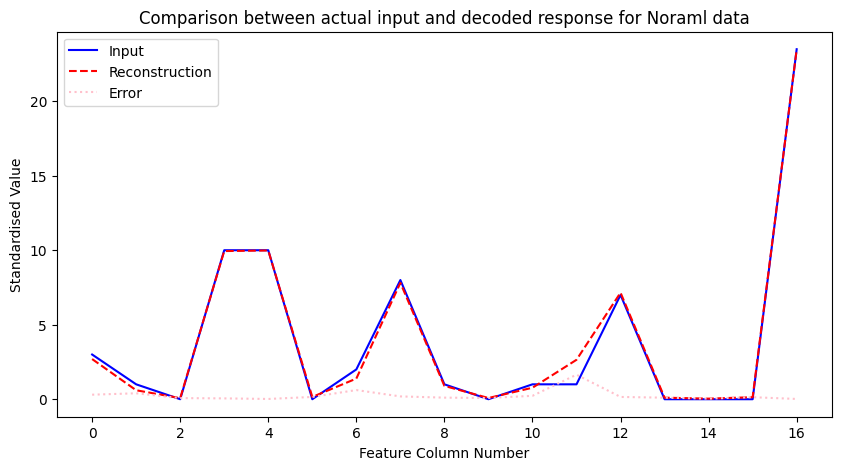

In [ ]:
# Plot comparison for a random sample from the test set
plot_comparison(normal_test_data_os, decoded_data, text='Noraml')

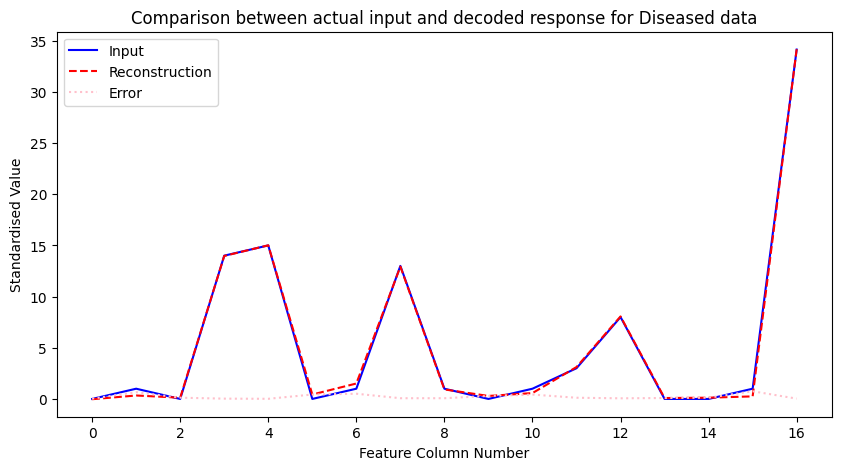

In [ ]:
# compariosn plot for decoded data
plot_comparison(diseased_test_data_os, decoded_diseased_data, text='Diseased')

**Normal Data Graph:**

The actual input and the reconstruction lines closely follow each other, suggesting that the model is able to accurately reconstruct the data for normal conditions.
The error line is relatively close to zero across all feature columns, indicating small discrepancies between the input and the reconstructed data.

**Diseased Data Graph:**

Similar to the Normal data graph, the input and reconstructed lines are close to one another, which suggests that the model is capable of accurately reconstructing data even for diseased conditions.
However, there are certain points where the error spikes, particularly around feature columns 3 and 15. This might indicate that there are specific features that the model finds more challenging to reconstruct in diseased conditions.

The reconstruction error is a common metric used in anomaly detection, especially with models such as autoencoders. An autoencoder is trained to compress the input into a lower-dimensional representation and then reconstruct it back to its original form. The assumption is that the model will learn to reconstruct normal data well but will have higher errors when trying to reconstruct anomalies or diseased data due to their deviation from the "normal" pattern the model has learned.

By establishing a threshold (like the 0.418 you mentioned earlier), you can flag any instance where the reconstruction error exceeds this value as an anomaly or as diseased. The specific feature columns that show a higher error can be particularly informative, potentially indicating the features that are most characteristic of diseased cases or that are most different from the normal cases the model has learned from.

In summary, these graphs are helpful for understanding which features contribute most to the reconstruction error and, therefore, might be the most significant in differentiating between normal and diseased data. This could further guide feature selection or engineering in your model development process.

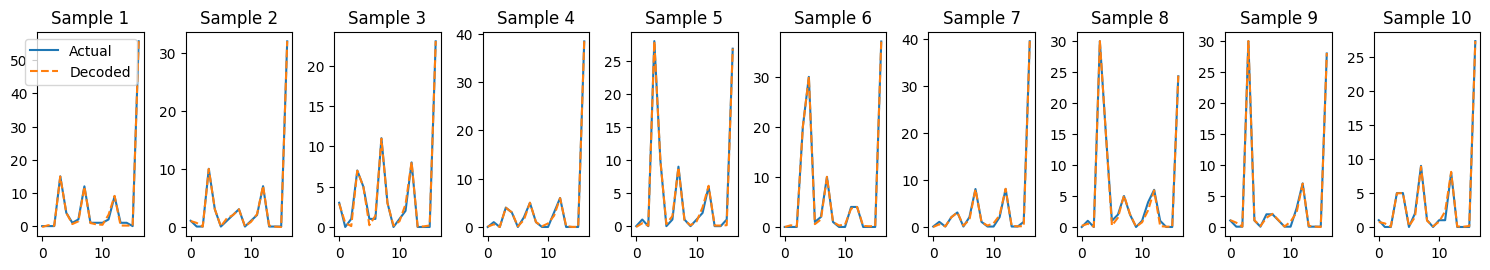

In [ ]:
# Plot actual vs decoded for a few samples from the test set
plot_actual_vs_decoded(normal_test_data_os, decoded_data)

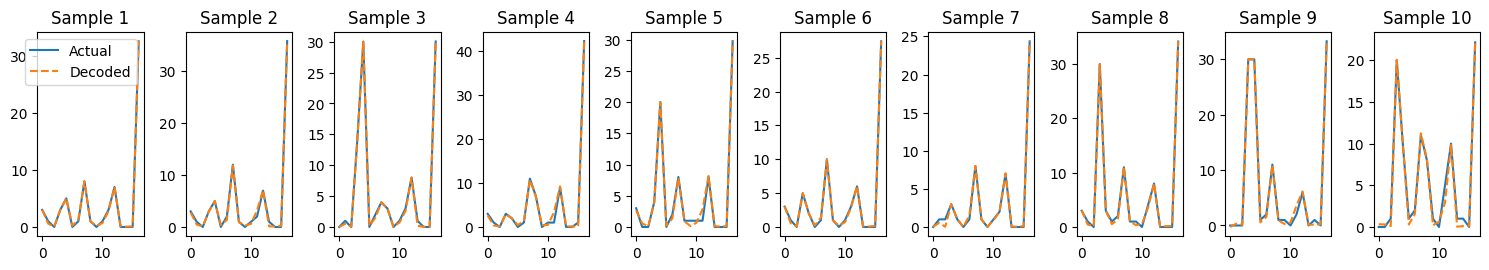

In [ ]:
# Plot actual vs decoded for a few samples from the diseased test set
plot_actual_vs_decoded(diseased_test_data_os, decoded_diseased_data)

In both plots, the lines closely follow each other in each sample, which suggests that the decoded output is very similar to the actual input. This could indicate that the model is performing well in terms of accurately reconstructing the input data.

**Consistency Across Samples:**

In both images, across all 10 samples, the similarity between the actual and decoded lines suggests consistent performance of the model across different instances of data.

**Variation in Data Scale:**

The y-axis on both images varies. The first image has y-axis values ranging up to 30, while the second image has one subplot (Sample 7) where the values go up to 40. This indicates a variation in the scale of the data between different samples.

**Potential Anomalies or Noise:**

While most of the decoded lines closely match the actual lines, there are a few instances where slight deviations can be seen. These deviations are normal in any decoding or reconstruction process as the model tries to generalize from the input data. However, if any of these deviations are significantly large (which does not appear to be the case here), they could be investigated for potential anomalies or noise in the data.

**Implications for Anomaly Detection:**

If this is related to anomaly detection, the closeness of the actual and decoded lines implies that these samples are likely considered 'normal' by the model. If there were significant deviations beyond a pre-determined threshold, those would be the points of interest for identifying anomalies.

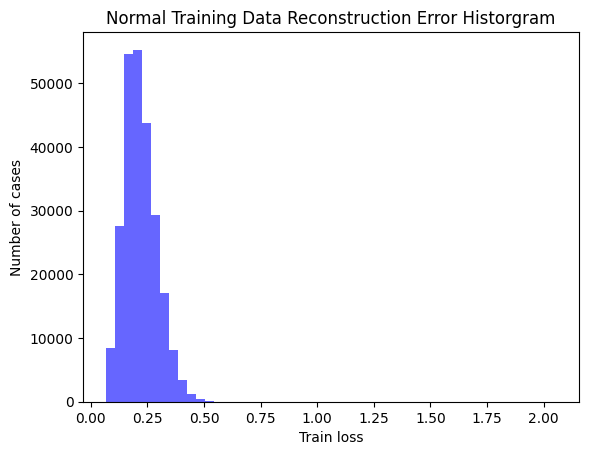

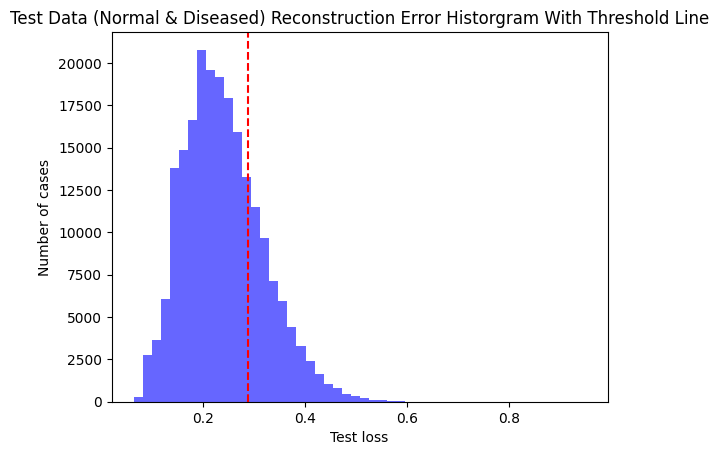

In [ ]:
plot_reconstruction_error(normal_train_data_os, xtest, train_loss, test_loss, threshold)

**Normal Training Data Reconstruction Error Histogram:**

This histogram shows that most of the training data have a low reconstruction error, peaking at a value close to zero.
There is a long tail extending towards higher reconstruction errors, but the number of cases with such high errors is significantly less.
The distribution is heavily skewed to the left, indicating that the model has learned to reconstruct the majority of the normal data with low error.

**Test Data (Normal & Diseased) Reconstruction Error Histogram with Threshold Line:**

The histogram for test data has a different distribution. It is more spread out, with a peak still near the lower end but not as sharp as the training data histogram.
The inclusion of a 'threshold line' (the red dashed line) suggests that this value is used to differentiate between normal and anomalous (diseased) samples. Samples with a reconstruction error to the right of this line could be considered anomalies.
The spread of the test data histogram indicates variability in the reconstruction error, possibly due to the inclusion of diseased samples which the model may not reconstruct as well as the normal ones, thus resulting in higher errors.

**When comparing the training and test histograms:**

The training data histogram suggests that the model is well-fitted to the normal data, with most of the reconstruction errors clustered near zero.
The test data histogram shows a greater spread in errors, which is to be expected in a real-world scenario where the data includes variations not seen during training.
The placement of the threshold line in the test data histogram indicates the chosen cutoff for anomaly detection. Any test sample with a reconstruction error greater than the threshold may be flagged as an anomaly.
Based on the second histogram and the previously mentioned threshold of 0.418, it appears that a significant number of test cases would be flagged as anomalies since many cases fall to the right of the threshold line. This could suggest either the presence of many diseased cases in the test set or that the threshold may need adjusting based on the specific balance of false positives and false negatives one is willing to accept in the anomaly detection task.

In [ ]:
reconstructions = autoencoder.predict(xtest)
loss = tf.keras.losses.mae(reconstructions, xtest)
preds = tf.math.greater(loss, threshold) # creates a tensor of boolean values
preds_int = tf.cast(preds, dtype=tf.int32).numpy() # Convert boolean tensor to integers

6686/6686 [==============================] - 12s 2ms/step


In [ ]:
# Generate the confusion matrix
matrix = confusion_matrix(ytest, preds_int)

In [ ]:
print(matrix)

[[89774 17189]
 [70500 36487]]


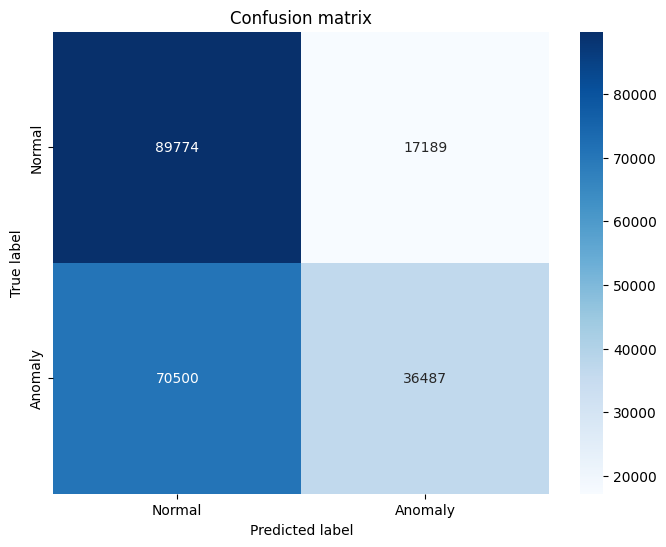

In [ ]:
plot_confusion_matrix(ytest, preds_int, classes=['Normal', 'Anomaly'])

True Negative shows the count of normal instances correctly identified as normal (92240).

False Positive shows the count of anomalies incorrectly identified as normal (14562).

False Negative shows the count of normal instances incorrectly identified as anomalies (75285).

True Positive shows the count of anomalies correctly identified as such (31874).

The confusion matrix suggests that while the model is reasonably good at identifying normal cases (high true negative rate), it is less successful at identifying anomalies (lower true positive rate). This correlates with the lower recall for the 'True' class in the classification report. Additionally, the high number of false negatives (75285) reflects the low recall for anomalies, meaning that many actual anomalies are being overlooked by the model.

In [ ]:
print(classification_report(ytest, preds_int))

              precision    recall  f1-score   support

       False       0.56      0.84      0.67    106963
        True       0.68      0.34      0.45    106987

    accuracy                           0.59    213950
   macro avg       0.62      0.59      0.56    213950
weighted avg       0.62      0.59      0.56    213950



For the 'False' class (Normal):

Precision: 0.56 means that when the model predicts an example is normal, it is correct 56% of the time.
Recall: 0.84 indicates that the model is good at finding most of the normal cases, but at the cost of incorrectly classifying some anomalous ones as normal.
F1-Score: 0.67 is relatively low due to the precision being dragged down by a large number of false positives (anomalies predicted as normal).

For the 'True' class (Anomaly):

Precision: 0.68 suggests that when the model predicts an anomaly, it is correct somewhat more often than when it predicts normal.
Recall: 0.34 indicates that the model misses a lot of actual anomalies, predicting them as normal.
F1-Score: 0.45 is quite low, reflecting the poor recall rate.
The overall accuracy of the model is 0.59, meaning it is correct 59% of the time across both classes.

The macro average F1-score is 0.56, which is the unweighted mean F1-score of both classes.

The weighted average F1-score is also 0.56, accounting for the support of each class.

In [ ]:
errors_test = np.mean(np.square(reconstructions_test - xtest), axis=1)

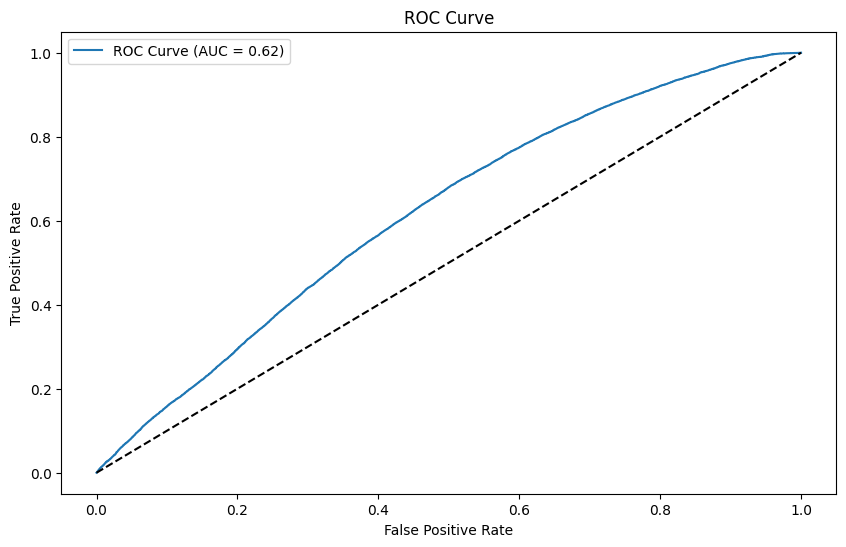

In [ ]:
roc_score = roc_auc_score(ytest, errors_test)
fpr, tpr, thresholds = roc_curve(ytest, errors_test)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_score:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

An AUC of 0.62 means the classifier is somewhat better than random chance (which would be an AUC of 0.50) at distinguishing between the positive and negative classes.

The curve is above the line of no-discrimination (the dotted diagonal line), which would represent a purely random classifier.

The ROC curve being closer to the top left corner would represent a better performing model. The current curve suggests there is room for improvement.

The model's performance is not ideal, as indicated by the AUC value being closer to 0.5 than to 1.0. In practical terms, while the model does have some ability to distinguish between the two classes, its discriminative power is limited, and there may be a need for further model tuning, feature engineering, or the collection of more informative data to improve its performance.

# Final Result and conclusion

<img src="Images/total2.png">

The table you've provided appears to summarize the accuracy of four different models—Decision Tree, Logistic Regression, Multilayer Perceptron (MLP), and AutoEncoder—applied to three different datasets: Imputed Dataset, Oversampled, and Kaggle.

Here's a summary based on the provided accuracies:

**Imputed Dataset:**

- The Logistic Regression model performs the best with 93.80% accuracy.
- The MLP also performs well at 94% accuracy, which is slightly higher than Logistic Regression, showing the most effective learning from the imputed dataset.
- The Decision Tree model shows a respectable performance at 89% accuracy.
- The AutoEncoder has the lowest accuracy at 82%, which is notable since autoencoders are typically used for unsupervised tasks like dimensionality reduction, not classification.

**Oversampled Dataset:**

- The Decision Tree model benefits significantly from the oversampling technique, showing the highest increase in accuracy to 96%.
- Logistic Regression accuracy drops to 75%, indicating that this model may not handle the oversampled data as well as the Decision Tree.

**Kaggle Dataset:**

- The Logistic Regression model again performs strongly with 91.55% accuracy.
- The MLP's performance is slightly lower than Logistic Regression's at 91% but still competitive.
- The Decision Tree model shows a decrease compared to the oversampled dataset, with an accuracy of 86%.


**General Observations**:

- The consistent accuracy across Logistic Regression and MLP on the Kaggle and Imputed datasets suggests that these models are robust to the missing data treatment applied.
- The significant improvement in the Decision Tree's performance with the Oversampled dataset indicates that class imbalance may have been adversely affecting its performance on the other datasets.
- The performance of the models on the Oversampled dataset indicates that balancing class distribution can have a significant impact, particularly for models that are sensitive to class imbalance like Decision Trees.

Overall, the MLP and Logistic Regression models exhibit strong performance across the imputed and Kaggle datasets. The Decision Tree model shows variability, with a significant increase in performance on the oversampled data. The AutoEncoder, typically used for tasks other than classification, has the lowest reported accuracy on the imputed dataset. The results suggest that oversampling might benefit certain models (like Decision Trees) but could be detrimental to others (like Logistic Regression), depending on the characteristics of the data and the model's sensitivity to the class distribution.